## Nb to establish expert level human performance on classifying YNet yeast data.



In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff
from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
%matplotlib inline

In [3]:
def tfms_for_test(sz):
    test_norm = Normalize(stats=None, IntNorm=True)
    test_denorm = None
    val_crop = CropType.NO
    test_tfms = image_gen(test_norm, test_denorm,sz, crop_type=val_crop)
    return test_tfms

In [4]:
def get_data(path: str, sz, bs): # , num_workers=1
    create, lbl2index, lbl2index_test = ImageClassifierData.prepare_from_path(path, val_name='val', bs=bs, num_workers = 8,                                                                            
                                                                             balance=True)
    augs = [RandomDihedral(),
            RandomRotate(90),
           ]
    
    tfms = tfms_with_IntNorm(sz, aug_tfms=augs, crop_type=CropType.CENTER, pad=sz[1]//8)
    test_tfms = tfms_for_test(sz)
    tfms += (test_tfms, )
    
    return create(tfms), lbl2index, lbl2index_test

In [5]:
# CLASSES = ('WT', 'mfb1KO', 'mmr1KO', 'mmm1KO', 'num1KO','LatA-5uM','CK666', 'fzo1KO', 'dnm1KO')

In [6]:
bs = 64
sz = [2,224,224]
path = "datasets/yeast_v11.3_manual/"

data, lbl2idx, lbl2idx_test = get_data(path,sz,bs)

# generate dict for manual annotation
lbl2index = {value[2]: value[1] for key, value in lbl2idx.items()}

Internal Normalization
val_crop is: 2
Internal Normalization
Using WeightedRandomSampler


In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display
from IPython.display import clear_output

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

def plot_acc_curve(preds, targs):
#     print(f"preds: {len(preds)},targets: {len(targs)}")
    acc_curve = [sum(preds[:i + 5] == np.asarray(targs[:i + 5])) / (i + 5) for i in range(len(targs) - 5)]
    plt.plot(acc_curve)
    
    
def on_button_clicked(pred):
    
    # converting to str and parsing to get description of the button clicked.
    _, cls, _ = str(pred).split("'")
    
    global idx
    global x
    global y
    global targs
    global preds
    global clss
    
    
    clear_output()
    
    if cls == 'Exit':
        print('Saving results...')
        df = pd.DataFrame({'predictions': preds, 'targets': targs}, columns=['predictions', 'targets'])
        if os.path.isfile(res_path + '.csv'): 
            m = 'a'
            print('appending...')
        else: m = 'w'
        df.to_csv(res_path + '.csv', index=False, mode=m)
        print(f"Results saved to {res_path}")
        print('evaluation...')
        
        plot_acc_curve(preds, targs)
        cm = confusion_matrix(targs,preds)
        plot_confusion_matrix(cm, data.classes)
        print(accuracy_score(preds, targs))
        print(classification_report(preds, targs, target_names=data.classes))     
       
    else:
        for c in clss:
            buttons = widgets.Button(description=c)
            buttons.on_click(on_button_clicked)
            display(buttons)

        preds.append(lbl2index[cls])
        targs.append(y[idx])
        
        if idx == (data.bs - 1):
            print('new Batch!')
            idx = 0
            x, y = next(iter(data.trn_dl)) 
            xx = x[idx].cpu().numpy().copy()
            plt.imshow(np.sum(xx, axis=0))

        else:
            idx = idx + 1
            # loading it from GPU to CPU
            xx = x[idx].cpu().numpy().copy()
            yy = y[idx]
            plt.imshow(np.sum(xx, axis=0))


        print(f"{preds[-1] == targs[-1]} prediction!")
        print(f"human-level accuracy: [{sum((np.asarray(preds)) == (np.asarray(targs))) / len(targs):4.4}]")
        
def manual_preds(save_path, investigator, loaded_preds = None, loaded_targs = None):    
    
    
#     from IPython.display import clear_output
    
    global idx
    global preds
    global targs
    global clss
    global res_path
    
    res_path = save_path + investigator

    if loaded_preds is not None and loaded_targs is not None:
        preds = loaded_preds
        targs = loaded_targs
        print(f"loaded...")
        print(f"current human-level accuracy: [{sum((np.asarray(preds)) == (np.asarray(targs))) / len(targs):4.4}]")
        print("continuing with new batch")
    else:
        preds = []
        targs = []
        print("no previous results loaded - fresh start")
        
    idx = 0
    clss = list(lbl2index.keys())
    clss.append('Exit')

    # creating buttons
    for c in clss:
        buttons = widgets.Button(description=c)
        buttons.on_click(on_button_clicked)
        display(buttons)
    
    # load first image:
    xx = x[idx].cpu().numpy().copy()
    yy = y[idx]
    plt.imshow(np.sum(xx, axis=0))

In [49]:
x, y = next(iter(data.trn_dl)) 

Saving results...
appending...
Results saved to datasets/yeast_v11.3_manual/manual_predictions_WP
evaluation...
preds: 204,targets: 204
0.46568627450980393
             precision    recall  f1-score   support

     mmm1KO       0.72      0.74      0.73        31
     num1KO       0.19      0.25      0.22        24
         WT       0.59      0.65      0.62        26
     mfb1KO       0.60      0.29      0.39        42
     mmr1KO       0.58      0.45      0.51        33
     dnm1KO       0.39      0.46      0.42        26
     fzo1KO       0.29      0.45      0.35        22

avg / total       0.50      0.47      0.47       204



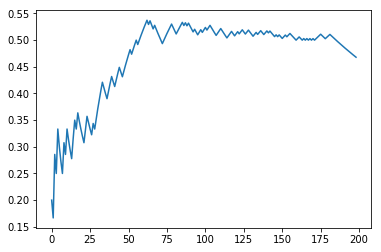

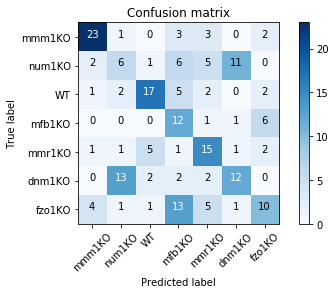

In [63]:
save_path = 'datasets/yeast_v11.3_manual/manual_predictions_'
investigator = 'WP'

manual_preds(save_path, investigator)

In [62]:
# df = pd.read_csv('datasets/yeast_v11.3_manual/manual_predictions_WP.csv')
# load_preds = list(df['predictions'])[1:]
# load_targs = list(df['targets'])[1:]

In [ ]:
# save_path = 'datasets/yeast_v11.3_manual/manual_predictions_'
# investigator = 'WP'

# manual_preds(save_path, investigator, load_preds, load_targs)